# State Space Models

_UNDER CONSTRUCTION_


- Gaussian Mixture Model

- Hidden Markov Models
  - Viterbi algorithm 

- Kalman Filter and Dynamic Factor Models



In [1]:
import re
import time
import random
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.api as sm
from hmmlearn import hmm
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from typing import List, Dict
from finds.readers import fred_md, fred_qd, Alfred
from finds.misc import Show
from secret import paths, credentials

show = Show(ndigits=4, latex=None)
VERBOSE = 0
# %matplotlib qt
imgdir = paths['images'] / 'states'

In [2]:
# Load and pre-process time series from FRED
alf = Alfred(api_key=credentials['fred']['api_key'])
vspans = alf.date_spans('USREC')  # to indicate recession periods in the plots

In [3]:
today = int(datetime.today().strftime('%Y%m%d'))
beg = 19600301
end = 20221231    # should be current less 4-6 months?
split = 20220601  # forecast last two quarters

FRED-MD
- replace outliers
- apply tcode transformations
- train/test split: train up to MINUS two quarters, forecast through current


In [4]:
#
#
# TODO: use EM to replace outliers in data
#
#
# Retrieve FRED-MD series and apply tcode transformations
df, t = fred_md()        # from vintage April 2020?
data = []
for col in df.columns:
    data.append(alf.transform(df[col], tcode=t['transform'][col], freq='m'))
mdf = pd.concat(data, axis=1).iloc[2:]
mdata = mdf[(mdf.index >= beg) & (mdf.index <= end)].dropna(axis=1)
mdata = (mdata - mdata.mean(axis=0)) / mdata.std(axis=0, ddof=0)
mdata.index = pd.DatetimeIndex(mdata.index.astype(str), freq='m')
mdata

monthly/current.csv


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
1960-03-31,-0.055906,-0.239279,1.361862,-2.436357,-0.373310,-1.128282,-0.544828,-0.288448,-0.030594,-0.670564,...,-0.251034,-1.387819,0.286975,-0.688081,-0.005209,3.346166,-1.006546,0.145331,0.048471,0.322440
1960-04-30,0.070437,0.197310,1.518351,0.617775,1.351158,-1.018832,0.046300,-0.071603,0.510438,-0.099990,...,1.588834,1.257955,0.711232,0.889271,-2.259533,-7.559300,0.000557,0.363396,0.275403,2.250783
1960-05-31,-0.014758,0.007897,-2.731964,-2.719109,-1.263778,-0.315496,0.397676,0.466734,0.398859,0.223473,...,-1.342564,-0.394294,-1.073753,0.360705,2.259270,4.621913,0.000557,-0.202301,-0.103697,0.351217
1960-06-30,-0.149637,-0.427661,-0.336036,0.517670,-0.390060,-1.503229,-1.370566,-1.260830,-0.785716,-0.387215,...,-0.311868,-0.801636,0.036861,-0.425122,-1.129832,-1.268962,0.000557,0.214617,0.374620,-0.935720
1960-07-31,-0.062582,-0.079816,-0.067982,-0.728275,-0.947820,-0.556224,-0.785820,-0.725112,-1.008340,-1.242847,...,0.682163,0.869009,0.293779,0.307193,1.124537,0.838260,0.000557,-0.457746,-0.165399,3.001718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.031812,0.268079,0.259747,1.120513,0.145295,-0.095970,0.117463,0.254708,0.145430,-0.254268,...,1.841999,2.128771,-0.404350,3.054382,-0.364202,0.306571,-0.772418,0.051969,0.071119,-0.431431
2022-09-30,-0.105971,-0.000502,-0.002497,-0.128454,-0.313545,0.095777,-0.137272,-0.231848,-0.406570,-0.193276,...,0.386374,-0.105260,0.628192,-0.070539,0.354791,-0.003621,0.682301,0.217847,-0.008291,-0.680035
2022-10-31,-0.107340,-0.775597,0.005934,-0.260730,0.360985,-0.314157,0.060215,0.222922,0.347623,0.342962,...,0.386478,-2.555433,1.999584,-0.833222,0.083418,-0.172316,0.081215,0.013922,0.108611,-0.412855
2022-11-30,-0.214863,-0.510423,-0.803318,-0.939377,-1.145908,-0.538102,-0.534353,-0.557796,-0.308918,-0.744716,...,-1.270842,-0.531799,-1.413324,-0.351634,0.258909,-0.069131,0.837302,0.067908,-0.003047,0.892882


## Hidden Markov Model


In [5]:

def hmm_summary(markov: hmm.GaussianHMM, X: DataFrame,
                lengths: List[int], matrix: bool = False) -> Dict:
    """Helper to return summary statistics from fitting Hidden Markov Model

    Args:
        markov: Fitted GaussianHMM 
        X: Input data of shape (nsamples, nfeatures)
        lengths: Lengths of the individual sequences in X, sum is nsamples
        matrix: Whether to return the transition and stationary matrices

    Returns:
        Dictionary of results in {'aic', 'bic', 'parameters', 'NLL'}
    """
    logL = markov.score(X, lengths)
    T = np.sum(lengths)      # n_samples

    n = markov.n_features    # number of features ~ dim of covariance matrix
    m = markov.n_components  # number of states
    k = markov.n_features + {"diag": m * n,    # parms in mean and cov matrix
                             "full": m * n * (n-1) / 2.0,
                             "tied": n * (n-1) / 2.0,
                             "spherical": m}[markov.covariance_type]
    p = m**2 + (k * m) - 1   # number of indepedent parameters of the model
    
    results = {'aic': -2 * logL + (2 * p),
               'bic': -2 * logL + (p * np.log(T)),
               'parameters': p,
               'NLL' : -logL}
    if matrix:   # whether to return the transition and stationary matrix
        matrix = DataFrame(markov.transmat_)\
            .rename_axis(columns='Transition Matrix:')
        matrix['Stationary'] = markov.get_stationary_distribution()
        results.update({'matrix': matrix})   # return matrix as DataFrame
    return results

In [6]:
## Compare covariance types in Gaussian HMM models 
out = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    for n_components in range(1,16):
        markov = hmm.GaussianHMM(n_components=n_components,
                                 covariance_type=covariance_type,
                                 verbose=False,
                                 tol=1e-6,
                                 random_state=42,
                                 n_iter=100)\
                    .fit(mdata.values, [len(mdata)])
        result = hmm_summary(markov, mdata, [len(mdata)])
        #print(n_components, Series(results, name=covariance_type).to_frame().T)
        result.update({'covariance_type': covariance_type,
                       'n_components': n_components})
        out.append(Series(result))
results = pd.concat(out, axis=1).T.convert_dtypes()

Model is not converging.  Current: -8356.536935223692 is not greater than -8356.536922138932. Delta is -1.3084760212223046e-05
Model is not converging.  Current: -20040.65225614991 is not greater than -20040.65225604072. Delta is -1.0919029591605067e-07
Fitting a model with 96108 free scalar parameters with only 90480 data points will result in a degenerate solution.
Fitting a model with 103515 free scalar parameters with only 90480 data points will result in a degenerate solution.
Fitting a model with 110924 free scalar parameters with only 90480 data points will result in a degenerate solution.
Model is not converging.  Current: -98907.84473039334 is not greater than -98907.84472817722. Delta is -2.216111170127988e-06
Model is not converging.  Current: -96262.11285136703 is not greater than -96262.11280305496. Delta is -4.831206751987338e-05
Model is not converging.  Current: -91059.2537900895 is not greater than -91059.25375594033. Delta is -3.414916864130646e-05
Model is not conver

In [7]:
## Find best bic's
best_bic = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    result = results[results['covariance_type'] == covariance_type]
    argmin = np.argmin(result['bic'])
    best_bic.append(result.iloc[[argmin]])
best_bic = pd.concat(best_bic, axis=0)
show(best_bic, caption="HMM best bic by covariance type:")

,aic,bic,parameters,NLL,covariance_type,n_components
HMM best bic by covariance type:,,,,,,
0,114858.0027,148438.3513,7260,50169.0013,full,1
19,205978.9381,222741.36,3624,99365.469,diag,5
30,114858.0027,148438.3513,7260,50169.0013,tied,1
59,210187.904,220590.4114,2249,102844.952,spherical,15


In [8]:
## display estimated transition and stationary distributions of best_bic
n_components = best_bic[best_bic['covariance_type'] == 'diag']['n_components']
n_components = int(n_components.iloc[0])
markov = hmm.GaussianHMM(n_components=n_components,
                         covariance_type='diag',
                         verbose=False,
                         tol=1e-6,
                         random_state=42,
                         n_iter=100)\
            .fit(mdata.values, [len(mdata)])
pred = DataFrame(markov.predict(mdata), columns=['state'], index=mdata.index)
matrix = hmm_summary(markov, mdata, [len(mdata)], matrix=True)['matrix']
show(matrix, caption="HMM stationary and transition probabilities")

Transition Matrix:,0,1,2,3,4,Stationary
HMM stationary and transition probabilities,,,,,,
0,0.8779,0.0355,0.0353,0.0512,0.0000,0.4144
1,0.0450,0.9053,0.0073,0.0424,0.0000,0.3638
2,0.3431,0.0577,0.5137,0.0855,0.0000,0.0464
3,0.1052,0.0980,0.0227,0.7664,0.0076,0.1740
4,0.0000,0.0000,1.0000,0.0000,0.0000,0.0013


__Plot predicted states__

In [9]:
def plot_states(modelname: str, labels: np.ndarray, beg: int, end: int,
                series_ids = ['IPMANSICS', 'SPASTT01USM661N']):
    """helper to plot predicted states"""

    # n_components markers
    n_components = len(np.unique(labels))
    markers = ["o", "s", "d", "X", "P", "8", "H", "*", "x", "+"][:n_components] 
    
    fig, axes = plt.subplots(len(series_ids),
                             ncols=1,
                             figsize=(10, 3 * len(series_ids)),
                             num=1,
                             clear=True)
    axes[0].set_title(f"{modelname.upper()} Predicted States", {'fontsize':12})

    # plot each selected series, with states colored
    for series_id, ax in zip(series_ids, axes.ravel()):
        df = alf(series_id)
        df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
        df = df[(df.index >= beg) & (df.index <= end)]
        for i, marker in zip(range(n_components), markers):
            df.loc[labels==i].plot(ax=ax,
                                   style=marker,
                                   markersize=2,
                                   color=f"C{i}",
                                   rot=0)
            ax.set_xlabel(f"{series_id}: {alf.header(series_id)}",
                          {'fontsize':8})
        for a,b in vspans:   # shade economic recession periods
            if (b > min(df.index)) & (a < max(df.index)):
                ax.axvspan(max(a, min(df.index)),
                           min(b, max(df.index)),
                           alpha=0.3,
                           color='grey')
        ax.legend([f"state {i}" for i in range(n_components)], fontsize=8)
    plt.tight_layout()
    plt.savefig(imgdir / f"{modelname.lower()}.jpg")

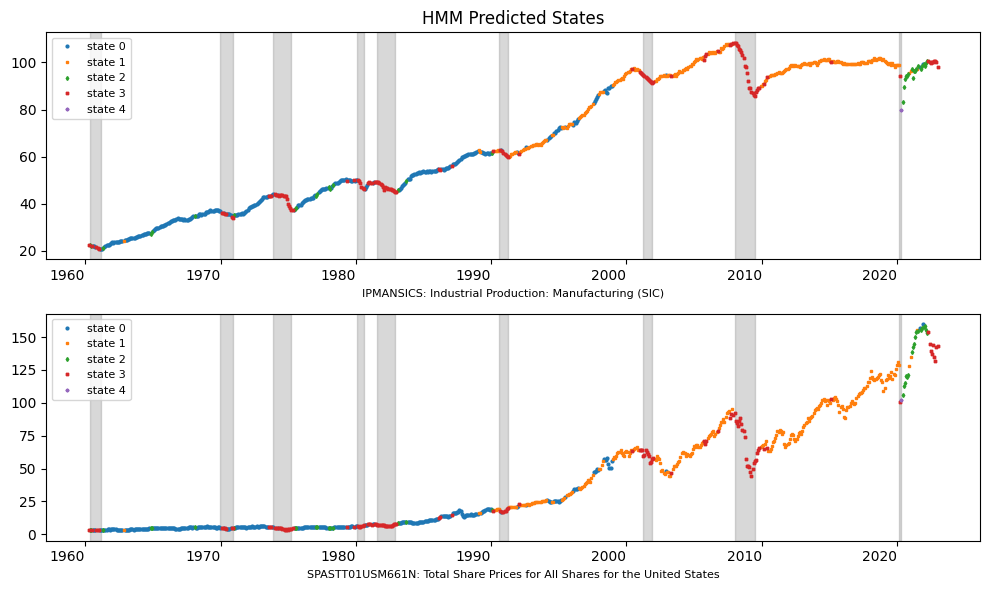

In [10]:
plot_states('HMM', pred.values.flatten(), min(pred.index), max(pred.index))

## Gaussian Mixture Model


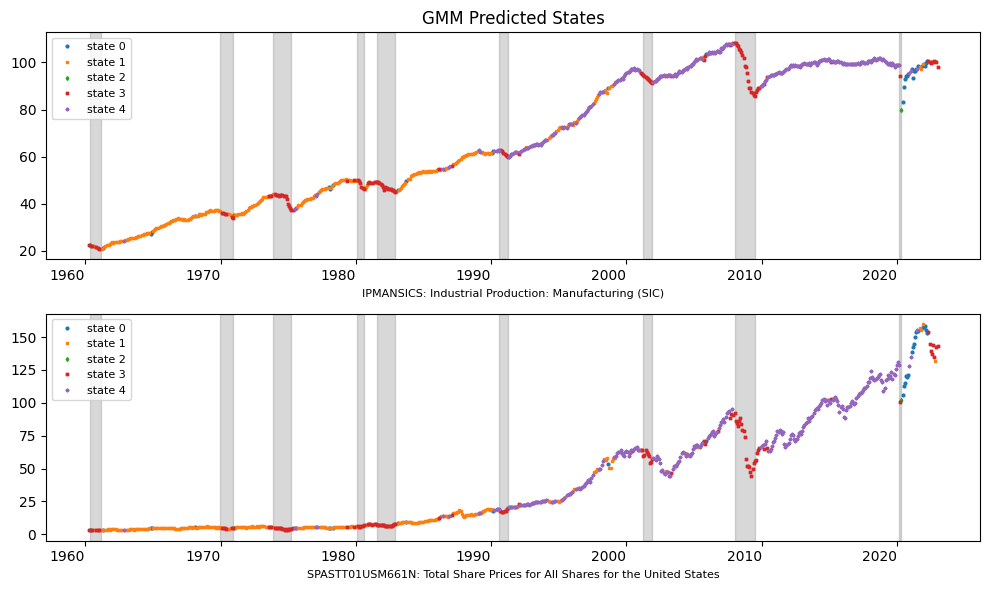

In [11]:
gmm = GaussianMixture(n_components=n_components,
                      covariance_type='diag')\
                      .fit(mdata)
labels = gmm.predict(mdata)
plot_states('GMM', labels, min(mdata.index), max(mdata.index))

In [12]:
## Compare persistance of HMM and GMM
dist = DataFrame({
    'Hidden Markov': (sorted(matrix.iloc[:,-1])
                      + [np.mean(pred[:-1].values == pred[1:].values)]),
    'Gaussian Mixture': (sorted(Series(labels).value_counts().sort_index()
                                / len(labels))
                         + [np.mean(labels[:-1] == labels[1:])])},
                 index=([f'Stationary probability of state {n_components-s-1}'
                         for s in range(n_components)]
                        + ['Average persistance of states']))
show(dist, caption="Compare HMM with GMM:")

,Hidden Markov,Gaussian Mixture
Compare HMM with GMM:,,
Stationary probability of state 4,0.0013,0.0013
Stationary probability of state 3,0.0464,0.0451
Stationary probability of state 2,0.1740,0.1658
Stationary probability of state 1,0.3638,0.3660
Stationary probability of state 0,0.4144,0.4218
Average persistance of states,0.8526,0.8181


In [13]:
## Retrieve FRED-MD series and apply tcode transformations
"""
df, t = fred_md(202004)        # from vintage April 2020?
data = []
for col in df.columns:
   data.append(alf.transform(df[col], tcode=t['transform'][col], freq='m'))
mdf = pd.concat(data, axis=1).iloc[2:]
mdata = mdf[(mdf.index >= beg) & (mdf.index <= end)].dropna(axis=1)
mdata = (mdata - mdata.mean(axis=0)) / mdata.std(axis=0, ddof=0)
mdata.index = pd.DatetimeIndex(mdata.index.astype(str), freq='m')
"""

"\ndf, t = fred_md(202004)        # from vintage April 2020?\ndata = []\nfor col in df.columns:\n   data.append(alf.transform(df[col], tcode=t['transform'][col], freq='m'))\nmdf = pd.concat(data, axis=1).iloc[2:]\nmdata = mdf[(mdf.index >= beg) & (mdf.index <= end)].dropna(axis=1)\nmdata = (mdata - mdata.mean(axis=0)) / mdata.std(axis=0, ddof=0)\nmdata.index = pd.DatetimeIndex(mdata.index.astype(str), freq='m')\n"

## Dynamic Factor Models


In [14]:
dynamic_factors = dict()
seq_len = 16
for i in [1, 2, 3, 4]:
    mod = sm.tsa.DynamicFactorMQ(endog=mdata,
                                 factors=1,               # num factor blocks
                                 factor_multiplicities=i, # num factors in block
                                 factor_orders=2,         # order of factor VAR
                                 idiosyncratic_ar1=False) # False=white noise
    fitted = mod.fit_em(disp=20,
                        maxiter=200,
                        full_output=True)
    dynamic_factors[i] = DataFrame(fitted.factors.filtered.iloc[seq_len+1:])
    dynamic_factors[i].columns = list(range(len(dynamic_factors[i].columns)))
#print(fitted.summary(0))

EM start iterations, llf=-1.166e+05
EM converged at iteration 14, llf=-1.1573e+05, convergence criterion=9.3327e-07 < tolerance=1e-06
EM start iterations, llf=-1.1229e+05
EM iteration 20, llf=-1.095e+05, convergence criterion=1.7942e-05
EM iteration 40, llf=-1.0947e+05, convergence criterion=4.786e-06
EM converged at iteration 57, llf=-1.0947e+05, convergence criterion=9.1845e-07 < tolerance=1e-06
EM start iterations, llf=-1.0663e+05
EM iteration 20, llf=-1.044e+05, convergence criterion=1.3871e-05
EM iteration 40, llf=-1.0438e+05, convergence criterion=3.7032e-06
EM converged at iteration 57, llf=-1.0438e+05, convergence criterion=9.9877e-07 < tolerance=1e-06
EM start iterations, llf=-1.0269e+05
EM iteration 20, llf=-99741, convergence criterion=1.3581e-05
EM iteration 40, llf=-99727, convergence criterion=3.2774e-06
EM converged at iteration 57, llf=-99724, convergence criterion=9.3062e-07 < tolerance=1e-06


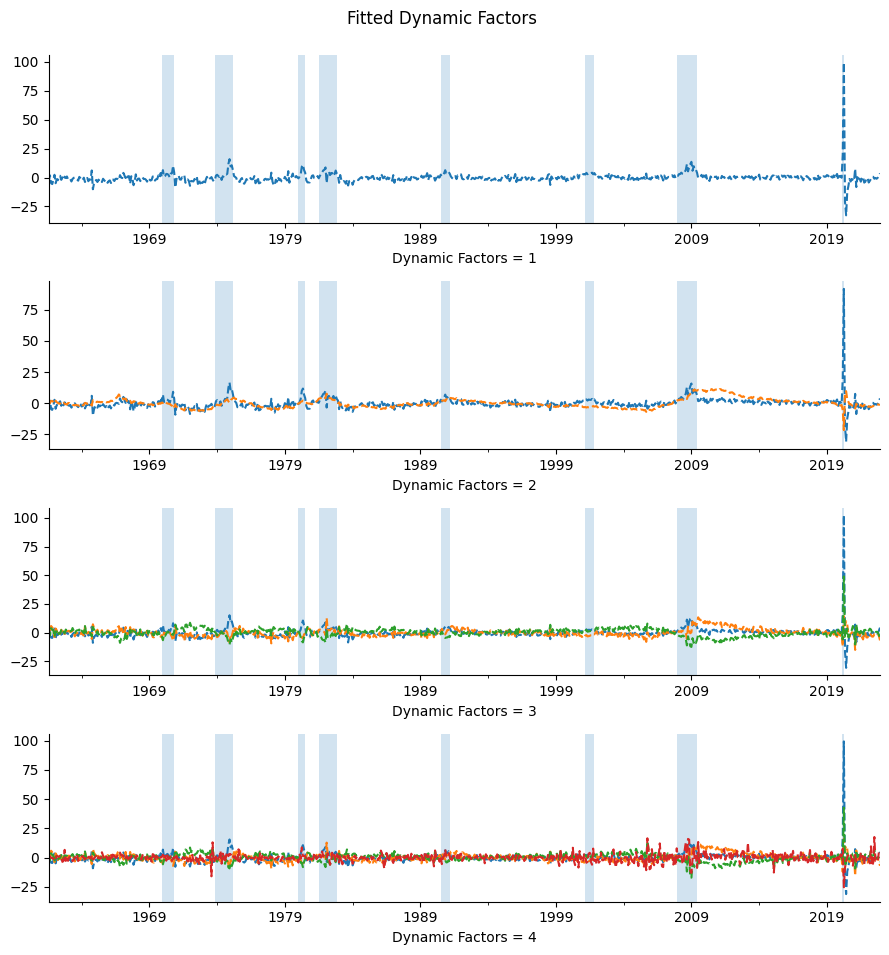

In [15]:
### Plot dynamic factors
fig, axes = plt.subplots(len(dynamic_factors),1,figsize=(9,10),num=1,clear=True)
for dynamic_factor, ax in zip(dynamic_factors.values(), axes):
    dynamic_factor.plot(ax=ax, style='--', legend=False)
    for a,b in vspans:
        if a >= min(dynamic_factor.index):
            ax.axvspan(a, min(b, max(dynamic_factor.index)), alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(f"Dynamic Factors = {len(dynamic_factor.columns)}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Fitted Dynamic Factors ", fontsize=12)
plt.savefig(imgdir / 'dynamic.jpg')